# Musical Instrument Recognition with Spectral Vectors and K-Means

Source: http://www.philharmonia.co.uk/explore/sound_samples/

In [17]:
# Capture Sound Samples

import numpy as np
from scipy import signal
import scipy.io.wavfile as sp
import os

#class that represents an instrument playing a specific note and its segments
class Instrument:
    def __init__(self, name, data, rate, segments):
        self.name = name             # instrument name
        self.data = data             # raw waves for the audio
        self.rate = rate             # sampling rate for the audio
        self.segments = segments     # segmented waves after fourier transform
        
#dictionary of the instruments
instruments = []
        
#iterate through all instrument folders in wav_data
directory = "data/wav_data/"
for folder in os.listdir(directory):
    if "." not in folder:
        #create an instrument object with the appropriate name per folder
        new_instrument = Instrument(folder, [], [], [])
        #iterate through all .wav files in folders
        for file_path in os.listdir(directory + folder):
            if file_path.endswith(".wav"):
                #rate = frames per second, data = the frames
                rate, data = sp.read(directory + folder + "/" + file_path)
                #append the data and rate for the sample
                new_instrument.data.append(data)
                new_instrument.rate.append(rate)
        #add instrument to instruments list
        instruments.append(new_instrument)   
        #print that new instrument was added
        print(new_instrument.name, 'added')
    
print('FINISHED')

snare_drum added
cello added
banjo added
violin added
french_horn added
trombone added
oboe added
bass_clarinet added
trumpet added
guitar added
triangle added
bass_drum added
saxophone added
tambourine added
tuba added
cowbell added
viola added
flute added
clash_cymbals added
double_bass added
FINISHED


## Feature Extraction
- Regularize to mean volume
- Get short time fourier transform
- Convert Segments into Spectral Vectors

In [18]:
# Rescaling and Spectral Vectors

import scipy

#find mean volume of sound samples 
lists_of_tops = [[np.max(sample) for sample in instrument.data] for instrument in instruments]
list_of_tops = [top for list_of_tops in lists_of_tops for top in list_of_tops]
mean_volume = np.mean(list_of_tops)  

#scale the volume for all the audio samples
def scale_volume(data, avg_volume = mean_volume):
    final_scale = avg_volume / (max(-1 * min(data), max(data)))
    return data * final_scale

def stft_custom(x, fs, framesz=0.025, hop=0.01):
    framesamp = int(framesz*fs)
    hopsamp = int(hop*fs)
    w = scipy.hanning(framesamp)
    X = scipy.array([scipy.fft(w*x[i:i+framesamp]) 
                     for i in range(0, len(x)-framesamp, hopsamp)])
    return X

#scale the data and perform stft
for instrument in instruments:
    for i in range(0, len(instrument.data)):
        
        #rescale data
        #instrument.data[i] = scale_volume(instrument.data[i])

        #get the data and rate
        data = instrument.data[i]
        rate = instrument.rate[i]

        #duration = number of frames / frames per second
        duration = len(data) / rate

        #overlap = frames per 10ms
        overlap = rate/1000*10
        overlap = int(overlap)

        #window_size = frames per 25ms
        window_size = rate/1000*25
        window_size = int(window_size)

        #extract frame segments with overlaps
        #f, t, Zxx = signal.stft(data, window = 'hann', nperseg = window_size, noverlap = overlap)
        Zxx = stft_custom(data, rate)
        
        #log of the absolute values of each segment
        Zxx = abs(Zxx)
        Zxx = [[np.log10(d) if d != 0 else 0.0 for d in segment] for segment in Zxx]
        
        #add the stft result to the instrument
        instrument.segments.append(Zxx)
        
        if i == 5: break # TODO remove limit on sample count
        
    print(instrument.name + ' segmented')
    
print('FINISHED')

snare_drum segmented
cello segmented
banjo segmented
violin segmented
french_horn segmented
trombone segmented
oboe segmented
bass_clarinet segmented
trumpet segmented
guitar segmented
triangle segmented
bass_drum segmented
saxophone segmented
tambourine segmented
tuba segmented
cowbell segmented
viola segmented
flute segmented
clash_cymbals segmented
double_bass segmented
FINISHED


## Plotting out sound samples 

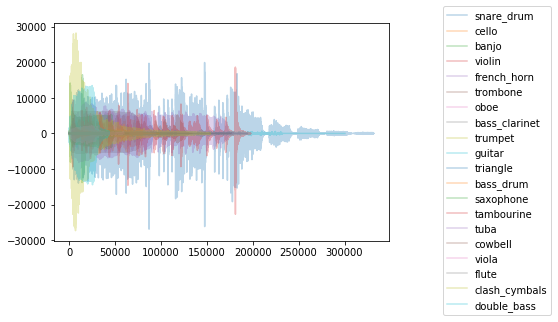

In [19]:
# Plot out all audio samples

import matplotlib.pyplot as plt
   
for instrument in instruments:
    plt.plot(instrument.data[0], label=instrument.name, alpha=0.3)
    
plt.legend(bbox_to_anchor=(1.5, 1.1))
plt.show()

## Multilayer Perceptron

In [20]:
# Prep Data
from sklearn.model_selection import train_test_split

X = []
y = []

for instrument in instruments:
    #print(instrument.name,'instrument.segments:',len(instrument.segments))
    for segments in instrument.segments:
        #print('\t segments length:',len(segments))
        for segment in segments:
            X.append(segment)
            y.append(instrument.name)
            #print('\t\t segment length:',len(segment))
    
X = np.array(X) 
y = np.array(y)

# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y)

print('Data was captured!')

Data was captured!


In [23]:
# sklean Multilayer Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

net = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

net.fit(X_train,y_train)
predictions = net.predict(X_test)

print('Accuracy on Train Set:', net.score(X_train,y_train))
print('Accuracy on Test Set:', net.score(X_test,y_test))
print('F1 Score:', f1_score(y_test,predictions,average='micro'))

Accuracy on Train Set: 0.33171427601
Accuracy on Test Set: 0.327593234155
F1 Score: 0.327593234155


In [24]:
# Cross Validate Results
from sklearn.model_selection import cross_val_score

k = 3
scores = cross_val_score(MLPClassifier(solver='lbfgs', alpha=1e-5,
                            hidden_layer_sizes=(5, 2), random_state=1), 
                         X, y, cv=k)
print(str(k) + '-Fold Score: ' + str(np.mean(scores)) + " (" + str(scores) + ")")

3-Fold Score: 0.281910885701 ([ 0.26  0.27  0.31])


## Confusion Matrix for Neural Network

Confusion matrix, without normalization
[[  98    0    0    6    0    0    0    0    0  334   19   64    0    0
     0    0    0    0    0    0]
 [   4    0    0   36    0    0    0    0    0    4   12  629    0    0
     0    0    0    0    0    0]
 [  22    0    4   59    0    0    0    0    0    4  126  229    0    0
     0    0    0    0    0    0]
 [  23    0    0   77    0    0    0    0    0    5   73  533    0    0
     0    0    0    0    0    0]
 [  26    0    0   63    0    0    0    0    0   16   58  176    0    0
     2    0    0    0    0    0]
 [  34    0    0   14    0    0    0    0    0   26   54    9    0    0
     0    0    0    0    0    0]
 [   9    0    0   52    0    0    0    0    0    0   64   68    0    0
     0    0    0    0    0    0]
 [ 169    0    0   22    0    0    0    0    0  312   97    8    0    0
     2    0    0    0    0    0]
 [  21    0    0   30    0    0    0    0    0   12   32  286    0    0
     0    0    0    0    0    0]
 [  45    0    

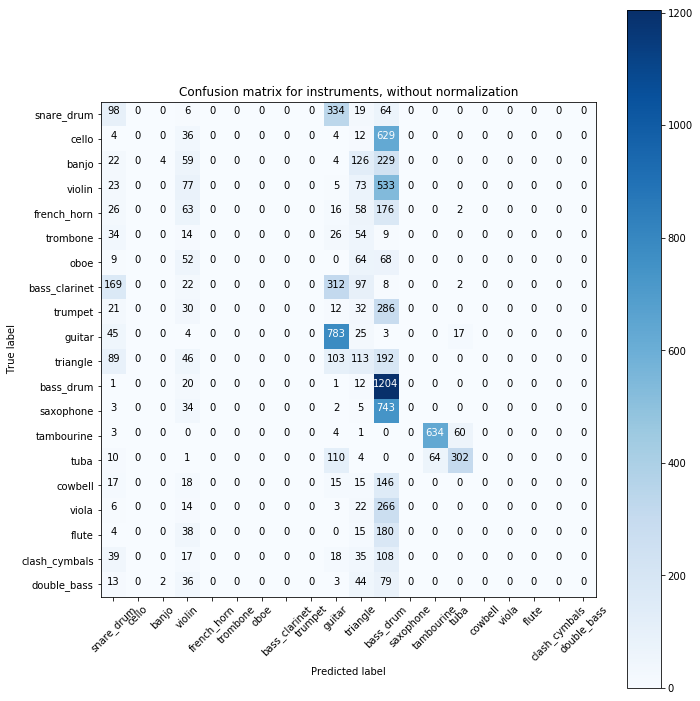

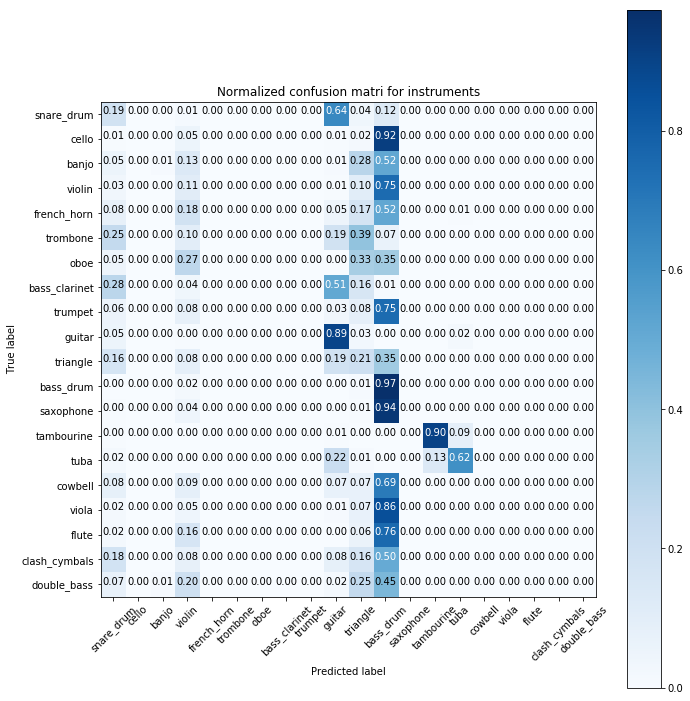

In [25]:
import itertools

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

confusion_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

instrument_names = [instrument.name for instrument in instruments]

plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix, classes=instrument_names,
                      title = 'Confusion matrix for instruments, without normalization')

plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix, classes=instrument_names, normalize=True,
                      title = 'Normalized confusion matri for instruments')
        
plt.show()

## Create Codebooks/Clusters for each instrument
- Clusters are generated with K-Means

In [27]:
from sklearn.cluster import KMeans

# For each codebook
kmeans = KMeans(n_clusters = 512, random_state = 1).fit(X)

# Store the resulting codebook: Return Centers
#kmeans.cluster_centers_

# Apply K-means to the spectral vector of each speaker so that at the end you have m
# codebooks for each speaker. For each speaker you can set the number of clusters (also
# known as codebooks) to 512.

# Now use your test data---for each speaker randomly assign 10% of data as the test---
# and compare the test spectral vectors of the input speaker to m codebooks of each
# speaker.

# Find the speaker whose spectral vector distant of its codebooks to the input spectral
# vectors is minimum. And select that speaker as the identified speaker from your
# machine.

## Evaluating Final Classifier
- Segment new signal and score on all instruments

In [8]:
# Return Centers
kmeans.cluster_centers_

array([[1., 1.],
       [0., 0.]])